In [23]:
import sys
import xlrd
import pandas as pd
import numpy as np
from numpy import median
import os
import fnmatch 
import random
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
import statistics
from scipy import signal
import math
from sklearn.linear_model import LinearRegression

In [66]:
cwd = os.getcwd()
print(cwd)
# Ribosome counts directory
#Ribocsv_dir = cwd+'/output/Glu_readd/EY-Ribo/'
Ribocsv_dir = cwd+'/output/Anna/'
# Polarity directory
polcsv_dir = cwd+'/outputcsv/Anna/'
#polcsv_dir = cwd+'/outputcsv/Glu_readd/EY-Ribo/'
# mRNA counts directory
RNAcsv_dir = cwd+'/output/Glu_readd/EY-RNA/'
# Delta Dhh1 file
dhh1file = cwd+'/Dhh1_Length_Short.xlsx'
tag = 'longmers_deduplicated_sorted_aligned_coding_NI-'
rna_tag = tag
#tag = 'Ribo'
#rna_tag = 'RNA'
# Define range of calculation samples and labels in bp
viewer = 1000*3
names = ['811','813', '815','817']
labels = ['logphase', '-Glu01','-Glu05', '-Glu15']
#names = ['15','7516','1517', '15118','15529']
names_r = ['24','7525','1526','15127','15511']
#labels = ['logphase', '-Glu075','-Glu15', '-Glu15+Glu1','-Glu15+Glu5']

#names = ['15','7516','1517']
#labels = ['logphase', '-Glucose 7.5min','-Glucose 15min']

# Range of genes: length in bp
d1 = 0
d2 = 7654321
# avgerage and number of codons to aggregate
# if avgerage is False, we do not avgerage(for sparse data)
avg = True
#num_cs = [5,10,15,20,25]
num_c = 15
# Dhh1 tag all, enriched, depleted
dhh1_tag = 'enriched'


df_samples_readd = pd.DataFrame()
df_samples_stress = pd.DataFrame()
stress = []
readd = []

/Users/jingxiaozhang/Desktop/elongation


In [67]:
## Load data and find concensus genes in length range
red = ['YLL026W', 'YDR258C', 'YPL240C', 'YBR169C', 'YER103W', 
       'YGR142W', 'YDR171W', 'YCR021C', 'YBR072W', 'YFL014W', 'YLR327C']
isred = []
df_dhh1_all = pd.read_excel(dhh1file)
df_dhh1_all = df_dhh1_all.set_index('Name')
namelist = df_dhh1_all.index
Ribocsv_list_s=[]
RNAcsv_list_s = []
for root,dirs,files in os.walk(Ribocsv_dir):
    for n in names:
        for file in files: 
            time = ''
            if file.split('.')[-1] == "csv" and tag in file:
                time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split(tag)[1].split('.csv')[0])) 
            if time == n:
                print(time)
                Ribocsv_list_s.append(Ribocsv_dir + file)
                dfribo = pd.read_csv(Ribocsv_dir + file)
                d2 = min(d2, max(dfribo.Length))
                dfribo = dfribo[(dfribo.Length >= d1)&(dfribo.Length <= d2)]
                reads_dict = dfribo.groupby(['Name']).agg({'Counts': np.sum,'Length':np.mean})
                reads_dict['CodonCoverage'] = reads_dict['Counts']/reads_dict['Length']*3
                
                if time == '811':
                    spread_cc = reads_dict['CodonCoverage'].quantile([0.05,0.25,0.5,0.75,0.95])
                    print(spread_cc)
                    reads_dict = reads_dict[reads_dict.CodonCoverage >= spread_cc.get(key=0.75)]
                namelist = list(set(namelist) & set(reads_dict.index))
                #print(len(reads_dict))
                #dfribo = dfribo[(dfribo.Name.isin(reads_dict.index))]

for root,dirs,files in os.walk(RNAcsv_dir):
    for n in names_r:
        for file in files: 
            time = ''
            if file.split('.')[-1] == "csv" and rna_tag in file:
                time = ''.join(filter(lambda i: i.isdigit(), file.split(rna_tag)[1].split('.csv')[0])) 
            if time == n:
                print(time)
                RNAcsv_list_s.append(RNAcsv_dir + file)
print('all files to measure in ' + Ribocsv_dir + ' is ',len(Ribocsv_list_s))
print('all files to measure in ' + RNAcsv_dir + ' is ',len(RNAcsv_list_s))
print('Number of genes ', len(df_dhh1_all))
print('Number of well translated genes ', len(namelist))

811
0.05    0.007189
0.25    0.041590
0.50    0.107547
0.75    0.318158
0.95    3.208384
Name: CodonCoverage, dtype: float64
813
815
817
all files to measure in /Users/jingxiaozhang/Desktop/elongation/output/Anna/ is  4
all files to measure in /Users/jingxiaozhang/Desktop/elongation/output/Glu_readd/EY-RNA/ is  0
Number of genes  4321
Number of well translated genes  715


In [68]:
df_dhh1 = df_dhh1_all[df_dhh1_all.index.isin(namelist)] 
#df_dhh1.to_csv(cwd+'/Dhh1_Length_Short_well_trans.xlsx')
print('total number of genes: ', len(df_dhh1))
spread_dhh1 = df_dhh1.Delta_Dhh1.quantile([0.25,0.5,0.65,0.75])
print(spread_dhh1)
low = spread_dhh1.get(key=0.25)
med = spread_dhh1.get(key=0.5)
high = spread_dhh1.get(key=0.75)

dhh1_enrich = df_dhh1[(df_dhh1.Delta_Dhh1 > med)]
dhh1_deplet = df_dhh1[(df_dhh1.Delta_Dhh1 < med)]
#dhh1_all = df_dhh1[(df_dhh1.Delta_Dhh1 > low)&(df_dhh1.Delta_Dhh1 < high)]
dhh1_all = df_dhh1
print('dhh1 enriched genes(-G-+G) ',len(dhh1_enrich))
print('dhh1 depleted genes(-G-+G) ',len(dhh1_deplet))
print('dhh1 all genes(-G-+G) ',len(dhh1_all))

if dhh1_tag == 'enriched':
    namelist = dhh1_enrich.index.tolist()
if dhh1_tag == 'depleted':
    namelist = dhh1_deplet.index.tolist()
if dhh1_tag == 'all':
    namelist = df_dhh1.index.tolist()

print(dhh1_tag, len(namelist))

total number of genes:  715
0.25   -0.468498
0.50    0.136986
0.65    0.484270
0.75    0.696426
Name: Delta_Dhh1, dtype: float64
dhh1 enriched genes(-G-+G)  357
dhh1 depleted genes(-G-+G)  357
dhh1 all genes(-G-+G)  715
enriched 357


In [69]:
def update_df(sample_agg_dict,df_samples,sample_time):
    temp_df = pd.DataFrame.from_dict(data = {'codon': list(sample_agg_dict.keys()), sample_time: list(sample_agg_dict.values())})
    temp_df = temp_df.set_index('codon')
    if len(df_samples) > 0: 
        #df_samples = pd.merge(df_samples, temp_df, how='inner', on = 'codon')
        df_samples = pd.merge(df_samples, temp_df, left_index=True, right_index=True)
    else:
        df_samples = temp_df  
    
    return df_samples

def smooth_codon(viewer,sample_rbf_dict,sample_label,i):
    global df_samples_readd,df_samples_stress,stress,readd
    
    # Smooth by codon sliding window
    reads = 0
    num_pos  = 0
    agg_dict = dict()
    for c in range(viewer):
        if c in sample_rbf_dict.index:
            left_c = max(1,c - int(num_c*3/2))
            right_c = c + int(num_c*3/2) + 1
            reads = sample_rbf_dict.loc[left_c:right_c,'NormCountsbp'].mean(axis=0) 
            agg_dict.update({c/3:reads})
            reads = 0
    # avg reads normalized ribosome reads per bp(not smoothed with codon window).
    #countsbp = np.array(list(agg_dict.values()))
    #sample_std = np.std(countsbp)
    #sample_mean = np.mean(countsbp)
    #sample_var = sample_std/sample_mean
    #counts_distribution = np.quantile(countsbp,[0.05,0.25,0.5,0.75,0.95])
    
    if '+Glu' in sample_label: 
        df_samples_readd = update_df(agg_dict,df_samples_readd,sample_label)
        readd.append(sample_label)
    elif '-Glu15' in sample_label:
        df_samples_stress = update_df(agg_dict,df_samples_stress,sample_label)
        stress.append(sample_label)
        df_samples_readd = update_df(agg_dict,df_samples_readd,sample_label)
        readd.append(sample_label)
    else:
        df_samples_stress = update_df(agg_dict,df_samples_stress,sample_label)
        stress.append(sample_label)
        
    #return counts_distribution,sample_std,sample_var
    
        

In [70]:
times = []
med = []
df_samples_readd = pd.DataFrame()
df_samples_stress = pd.DataFrame()
stress = []
readd = []
dict_samples = []
med_rs = []

for i in range(len(Ribocsv_list_s)):
    file = Ribocsv_list_s[i]
    time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split('.csv')[0])) 
    label = labels[names.index(time)]
    print(label)
    times.append(label)
    df = pd.read_csv(file)
    df = df[(df.Name.isin(namelist))]
    
    sf_dict = df.groupby(['RelativePosition']).agg({"Counts": np.sum, "Name": pd.Series.nunique})
    #sf = 1
    sf = sf_dict[(sf_dict.index >= 800)&(sf_dict.index <= 1500)].Counts.mean(axis=0)
    print(sf)
    df['Counts'] = df['Counts']/sf
    
    reads_dict = df.groupby(['Name']).agg({'Counts': np.sum,'RelativePosition':pd.Series.nunique,'Length':np.mean})
    reads_dict['ReadDensity'] = reads_dict['Counts']/reads_dict['RelativePosition']

    # Normalize raw ribosome reads by avg reads/read position (Gene specific)
    counts = []
    for k in range(len(df)):
        name = df.iloc[k,0]
        count = df.iloc[k,-1]
        counts.append(count/reads_dict.loc[name,'ReadDensity'])
    df['NormCounts'] = counts  
    
    # Aggreggate by position
    rbf_dict = df.groupby(['RelativePosition']).agg({"NormCounts": np.sum, "Name": pd.Series.nunique})
    rbf_dict['NormCountsbp'] = rbf_dict['NormCounts']/rbf_dict['Name']
    
    # merge all samples
    smooth_codon(viewer,rbf_dict,label,i)
    '''
    print('In sample ', label, ' number of genes used ', len(reads_dict.Counts))
    print('In sample ', label, ' number of positions covered ', len(rbf_dict))
    print('In sample ', label, ' variability of avg reads normed ribosome reads per bp is',sample_std,sample_var)
    print('In sample ', label, ' distribution of avg reads normed ribosome reads per bp is')
    print(counts_distribution)    
    '''

logphase
142.12410841654778
-Glu01
294.83880171184023
-Glu05
216.66761768901569
-Glu15
221.54636233951499


In [71]:
df_samples = df_samples_stress
df_samples['pseudoref'] = stats.gmean(df_samples.loc[:,times],axis=1)
for t in times:  
    ratio = df_samples[t]/df_samples['pseudoref']
    norm_r = statistics.median(ratio)
    normed = list(df_samples[t]/norm_r)
    df_samples[t] = normed
df_samples = df_samples.drop(columns=['pseudoref'])
select_times = df_samples.columns[-4:]
df_samples_all = df_samples.loc[:,select_times]
df_samples_all = df_samples_all[(df_samples_all.index>=math.ceil(1/3))&(df_samples_all.index<=int(1500/3))]
print(len(df_samples_all))

1498


In [72]:
fig = go.Figure()
all_l = []
meds = []
rng = d1
time_course = [0,1*60, 5*60, 15*60]
prev_peak = 0
el_y = 0
el_x = []
peaks = []
rates = []
for i in range(len(select_times)):
    t = select_times[i]
    #t = times[i]+'_normed'
    fit_y = df_samples_all[t]
    fig.add_trace(go.Scatter(x=df_samples_all.index, y = fit_y,mode='lines',name= t.split('_')[0]))

fig.update_layout(
    template='simple_white',
    title_text="Normalized ribosome reads at codon position for " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    xaxis_title="Codon position",
    #xaxis_title="Codon position(" + str(num_c) + " codons sliding window)",
    yaxis_title="Normalized ribosome reads(unsmoothed)"
)       

#fig.update_xaxes(range=[15/3, int(2000/3)])

fig.show()

In [73]:
fig = go.Figure()
all_l = []
meds = []
rng = d1
time_course = [0,1*60, 5*60, 15*60]
prev_peak = 0
el_y = 0
el_x = []
peaks = []
rates = []
for i in range(len(select_times)):
    t = select_times[i]
    if i == 0:
        name= 'reference'
        t_prev = select_times[0]
    else:
        name= 'delta ' + t.split('_')[0]
        t_prev = select_times[i-1]
        
    fit_y = df_samples_all[t]-df_samples_all[t_prev]
    fig.add_trace(go.Scatter(x=df_samples_all.index, y = fit_y,mode='lines',name = name))

fig.update_layout(
    template='simple_white',
    title_text="Possible elongation SL in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    xaxis_title="Codon position(" + str(num_c) + " codons sliding window)",
    yaxis_title="Delta Normalized ribosome reads(unsmoothed)"
)       

#fig.update_xaxes(range=[15/3, int(2000/3)])
fig.update_yaxes(range=[-0.5, 0.3])

fig.show()

In [74]:
def estimate_runoff_by_ratio(L_c,i,discrete):
    global df_readd_ratio,df_stress_ratio,time_course, select_times,skips 
    t = select_times[i]
    t_insec = time_course[i]
    skip = skips[i]
    
    ratio_dict = dict()
    runoff_dict = dict()
    rate_dict = dict()
    prev_l = skip
    prev_t = 0.0
    prev_r = 1.0
    
    for l in L_c:
        if l <= prev_l:
            avgread_t = 2.0
            avgread_0 = 1.0
            
        else:
            if discrete == False:
                df_t = df_samples_all[(df_samples_all.index > skip)&(df_samples_all.index <= l)][t]
                df_0 = df_samples_all[(df_samples_all.index > skip)&(df_samples_all.index <= l)][select_times[0]]
                
            
            avgread_t = statistics.mean(df_t)
            avgread_0 = statistics.mean(df_0)
        
        ratio = avgread_t/avgread_0
        runoff_t = t_insec/(prev_r-ratio)
        rate = (l-prev_l)/(runoff_t-prev_t)
        
        
        if ratio < 1.0 and runoff_t > 0:
            ratio_dict.update({l:ratio})
            runoff_dict.update({l:runoff_t})
            rate_dict.update({l:rate})
            prev_l = l
            prev_t = runoff_t
        
    if '+Glu' in t: 
        df_readd_ratio = update_df(ratio_dict,df_readd_ratio,t+'_ratio')
        df_readd_ratio = update_df(runoff_dict,df_readd_ratio,t+'_deplet_time')
        df_readd_ratio = update_df(rate_dict,df_readd_ratio,t+'_est_elong')
    elif '-Glu15' in t:
        df_stress_ratio = update_df(ratio_dict,df_stress_ratio,t+'_ratio')
        df_readd_ratio = update_df(ratio_dict,df_readd_ratio,t+'_ratio')
        df_stress_ratio = update_df(runoff_dict,df_stress_ratio,t+'_deplet_time')
        df_readd_ratio = update_df(runoff_dict,df_readd_ratio,t+'_deplet_time')
        df_stress_ratio = update_df(rate_dict,df_stress_ratio,t+'_est_elong')
        df_readd_ratio = update_df(rate_dict,df_readd_ratio,t+'_est_elong')
    else:
        df_stress_ratio = update_df(ratio_dict,df_stress_ratio,t+'_ratio')
        df_stress_ratio = update_df(runoff_dict,df_stress_ratio,t+'_deplet_time')
        df_stress_ratio = update_df(rate_dict,df_stress_ratio,t+'_est_elong')
        

## look for skips: skip build-up ribosomes due to low elongation rate

In [75]:
df_readd_ratio = pd.DataFrame()
df_stress_ratio = pd.DataFrame()
# Do Not Change This Part
L_c = df_samples_all.index.tolist()
time_course = [0,1*60, 5*60, 15*60]

# test for skips
#skips = [0,5,73,146]
skips = [0,5,68,150]

for i in range(1,len(select_times)):
    print(i)
    estimate_runoff_by_ratio(L_c,i,False)
# Do Not Change This Part
df_est = df_stress_ratio[(df_stress_ratio > 0).all(1)]

for i in range(1,len(select_times)):
    t = select_times[i] +'_est_elong'
    print(t)
    dis = df_est.loc[:,t].quantile([0.05,0.25,0.5,0.75,0.95])
    df_est = df_est[df_est[t] <= dis.get(key = 0.95)]
    
colors = ['blue', 'orange', 'green', 'red']

1
2
3
-Glu01_est_elong
-Glu05_est_elong
-Glu15_est_elong


In [76]:
fig = go.Figure()
for i in range(1,len(select_times)):
    t = select_times[i] +'_ratio'
    sample_color = colors[i]
    fit_y = np.array(df_est.loc[:,t])
    fig.add_trace(go.Scatter(x = df_est.index, y = fit_y,mode='lines',line=dict(color=sample_color),name = t))

fig.update_layout(
    template='simple_white',
    title_text="Relative averaged ribosome density in first L codons in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    yaxis_title="Relative averaged ribosome density",
    xaxis_title="L values (in codon)"
)       

#fig.update_xaxes(range=[15/3, 2000/3])

fig.show()

In [77]:
fig = go.Figure()
rate = []
for i in range(1,len(select_times)):
    t = select_times[i] +'_deplet_time'
    sample_color = colors[i]
    x = np.array(df_est.index).reshape(-1, 1)
    raw_y = np.array(df_est.loc[:,t]).reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(x, raw_y)

    # predict y from the data
    fit_y = model.predict(x)
    print('Estimated elongation rate(By derivative) is :', 1/(model.coef_.reshape(-1)[0]))
    rate.append(1/(model.coef_.reshape(-1)[0]))
    fig.add_trace(go.Scatter(mode='markers',x = x.reshape(-1),y = raw_y.reshape(-1),marker=dict(color=sample_color,size = 4),name= t))
    fig.add_trace(go.Scatter(mode='lines',x = x.reshape(-1),y = fit_y.reshape(-1),line=dict(color=sample_color)))
    
fig.update_layout(
    template='simple_white',
    title_text="Estimated time for depletion in first L codons in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    yaxis_title="Estimated Time in sec",
    xaxis_title="L values (in codon)"
)       

fig.show()    
    
    

Estimated elongation rate(By derivative) is : 0.3270741076450853
Estimated elongation rate(By derivative) is : 0.0426794413585422
Estimated elongation rate(By derivative) is : 0.009367620983814866


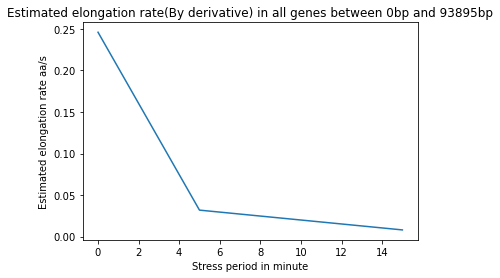

In [41]:
fig = plt.figure()
ax = plt.axes()
x = [0,5,15]
ax.plot(x, rate)
plt.title("Estimated elongation rate(By derivative) in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s");

In [28]:
fig = go.Figure()
rate = []
for i in range(1,len(select_times)):
    t = select_times[i] +'_est_elong'
    sample_color = colors[i]
    x = np.array(df_est.index).reshape(-1, 1)
    raw_y = np.array(df_est.loc[:,t]).reshape(-1, 1)
    
    model = LinearRegression()
    result=model.fit(x, raw_y)

    # predict y from the data
    fit_y = model.predict(x)
    print('coefficient of determination R^2 of the prediction is :', result.score(x, raw_y))
    rate.append(1/(model.coef_.reshape(-1)[0]))
    fig.add_trace(go.Scatter(mode='markers',x = x.reshape(-1),y = raw_y.reshape(-1),marker=dict(color=sample_color,size = 4),name= t))
    fig.add_trace(go.Scatter(mode='lines',x = x.reshape(-1),y = fit_y.reshape(-1),line=dict(color=sample_color)))
    
fig.update_layout(
    template='simple_white',
    title_text="Estimated elongation rate(By increment) in first L codons in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    yaxis_title="Estimated elongation rate in aa/sec",
    xaxis_title="L values (in codon)"
)       

fig.show() 

coefficient of determination R^2 of the prediction is : 0.07637389699918928
coefficient of determination R^2 of the prediction is : 0.45508370199533954
coefficient of determination R^2 of the prediction is : 0.3032950261422157
